In [1]:
import nltk
import bs4
import re
import pandas as pd
import requests
import scipy
import spacy

In [4]:
#import en_core_web_lg
scipy.__version__

'1.10.1'

In [5]:
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [6]:
#pip install -U pip setuptools wheel
#pip install -U spacy
#!python -m spacy download en
#!python -m spacy download en_core_web_lg 
# these commands needed to install spacy

In [7]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 

In [8]:
import networkx as nx
import scipy

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [9]:
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")

What is word2vec? 
Word2Vec is a technique in natural language processing (NLP) for generating high-quality, low-dimensional vector representations of words. These vector representations are used to capture the meaning of words in a way that allows computers to understand natural language text.

The Word2Vec model typically takes a large corpus of text as input and learns vector representations of words based on their co-occurrence patterns in the corpus. The model can be trained using either a skip-gram or continuous bag-of-words (CBOW) approach. In skip-gram, the model predicts the context words surrounding a target word, while in CBOW, the model predicts the target word based on the context words.

For example, let's consider the following sentence:

"The cat sat on the mat"

In a Word2Vec model, each word in this sentence would be represented as a vector of numbers. These vectors would be learned by analyzing the co-occurrence patterns of words in a large corpus of text.

Suppose we trained a Word2Vec model using this sentence and a large corpus of text. The resulting vector representation of the word "cat" might look something like this:

[0.2, -0.1, 0.4, -0.3, 0.1]
Similarly, the vector representation of the word "mat" might look like this:

[0.3, 0.2, -0.1, -0.4, 0.5]

These vector representations encode the meaning of each word in a way that can be used for various NLP tasks such as sentiment analysis, text classification, and machine translation.


In [10]:
candidate_sentences.shape

(4318, 1)

In [11]:
candidate_sentences['sentence'].sample(5)

177          jim reacts angrily but freddie apologises and the two chat and share a kiss.
1903                                                  the film was given an imax release.
3378    through their persistence, local feature film production was born and survived.\n
2470                     documentary translators very often have to meet tight deadlines.
1969       transgressive films imported from cultures that are recognizably different yet
Name: sentence, dtype: object

In [12]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [13]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [14]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [15]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:28<00:00, 153.03it/s]


In [16]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'men']]

In [17]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern],on_match=None) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [18]:
get_relation("John completed the task")

'completed'

In [19]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:30<00:00, 140.81it/s]


In [20]:
pd.Series(relations).value_counts()[:50]

is               364
was              308
released on       90
are               74
include           73
were              68
released          41
's                39
composed by       34
became            31
have              31
has               30
become            28
released in       27
included          23
had               21
produced          21
been              20
called            19
used              19
considered        18
made              18
scheduled         17
be                17
directed by       16
stars             16
hired             14
produced by       14
written by        13
wrote             13
received          13
introduced in     13
went              13
wanted            12
sold              12
began in          11
set               11
began             11
cast as           11
won               11
gave              10
directed          10
includes          10
gives              9
going              9
produced in        9
opened             9
features     

In [24]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [22]:
kg_df.head()

,source,target,edge
0,connie,own,decides
1,later scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,,outside cult him,wails with


In [23]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

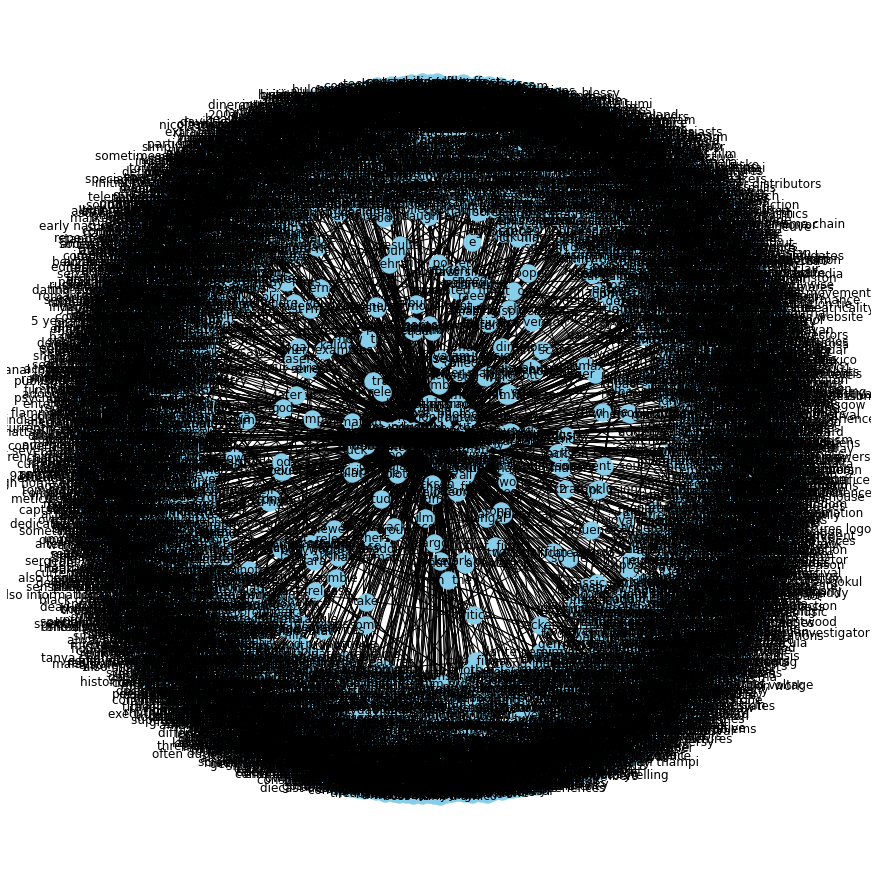

In [25]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

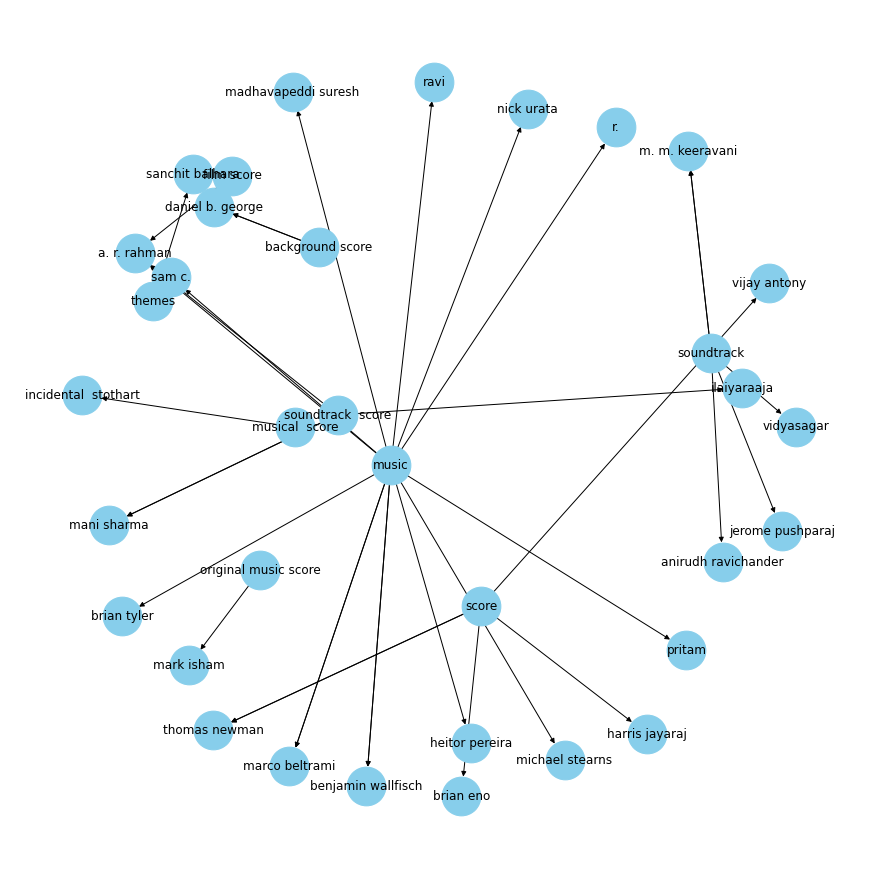

In [26]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

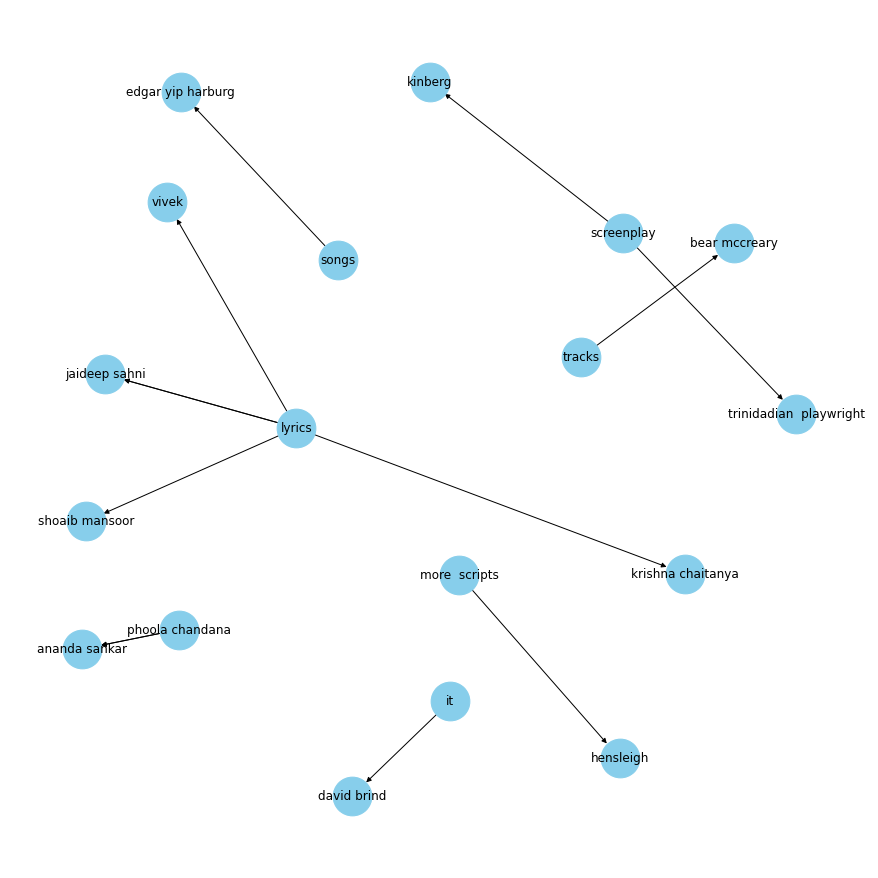

In [27]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

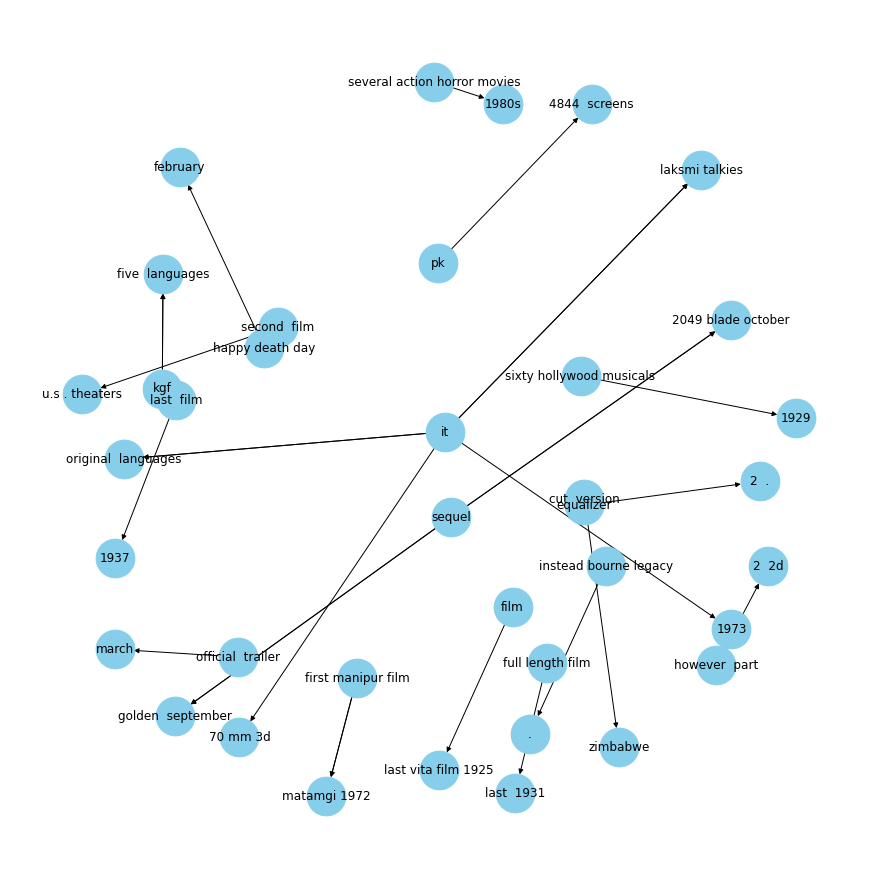

In [28]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [29]:
doc = nlp("Company Y is planning to acquire stake in X company for $23 billion")
for token in doc:
    print(token.text, token.pos_, token.dep_)

Company NOUN compound
Y PROPN nsubj
is AUX aux
planning VERB ROOT
to PART aux
acquire VERB xcomp
stake NOUN dobj
in ADP prep
X NOUN compound
company NOUN pobj
for ADP prep
$ SYM quantmod
23 NUM compound
billion NUM pobj


In [36]:
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [37]:
displacy.render(doc, style="dep" , jupyter=True)

In [38]:
spacy.explain("nsubj"), spacy.explain("ROOT"), spacy.explain("aux"), spacy.explain("advcl"), spacy.explain("dobj")

('nominal subject',
 'root',
 'auxiliary',
 'adverbial clause modifier',
 'direct object')

In [39]:
for token in doc:
    # Print the token and its part-of-speech tag
    print(token.text, "-->", token.dep_)

Reliance --> nsubj
is --> aux
looking --> ROOT
at --> prep
buying --> pcomp
U.K. --> npadvmod
based --> amod
analytics --> nsubj
startup --> conj
for --> prep
$ --> quantmod
7 --> compound
billion --> pobj


In [40]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Reliance 0 8 ORG
U.K. 30 34 GPE
$7 billion 63 73 MONEY


In [41]:
entities=[(i, i.label_, i.label) for i in doc.ents]
entities

[(Reliance, 'ORG', 383), (U.K., 'GPE', 384), ($7 billion, 'MONEY', 394)]

In [42]:
displacy.render(doc, style = "ent",jupyter = True)

In [7]:
nltk.download('brown')
from nltk.corpus import brown
brown.categories()

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\elham.nourghassemi\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Unzipping corpora\brown.zip.


['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

##### try to find some example of document clustering , pattern identification, product insights, security monitoring, sentiment analysis, text mining, 

In [9]:
nltk.download('stopwords')
from nltk.corpus import stopwords
set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elham.nourghassemi\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Unzipping corpora\stopwords.zip.


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [11]:
from nltk.stem import PorterStemmer
word_stemmer = PorterStemmer()
word_stemmer.stem('dancing')

'danc'

In [16]:
nltk.download()
from nltk.tokenize import word_tokenize
word_tokenize('this is first', language= 'english')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


['this', 'is', 'first']

In [17]:
from nltk.tokenize import word_tokenize
word_tokenize('this is first')

['this', 'is', 'first']